In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

In this notebook, I apply k-nearest neighbours classification (KNN) to a toy dataset. KNN is a non-parametric method that works well with data in which the classification boundary is irregular. To that effect, I will first create such type of dataset by randomly splitting the 2D plane by means of an irregular classification border and then sampling some training data. 

## Create the toy dataset

In [2]:
np.random.seed(0)

We use gaussian mixtures to split the 2D space into areas in which each of the two classes in the toy dataset have a higher likelihood. Each class is defined by a mixture of 5 2D Gaussian distributions with random means and identity covariance matrix.

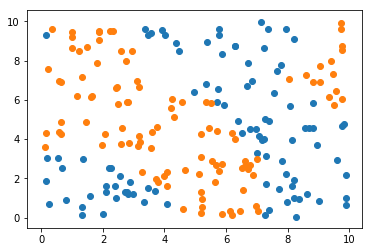

In [3]:
NUMBER_MEANS = 10
NUMBER_SAMPLES = 200

means_0 = (np.random.random_sample(2 * NUMBER_MEANS) * 10).reshape(NUMBER_MEANS, 2)
means_1 = (np.random.random_sample(2 * NUMBER_MEANS) * 10).reshape(NUMBER_MEANS, 2)

def pdf_2d_norm(y, x, mean):
    dif = np.array([y, x]) - mean
    product = np.dot(np.dot(dif.T, np.linalg.inv(np.identity(2))), dif)
    return (2 * math.pi) ** (-1) * np.linalg.det(np.identity(2)) ** (-0.5) * math.exp(-0.5 * product)

xs = []
ys = []
labels = []
for s in range(NUMBER_SAMPLES):
    ys.append((np.random.random_sample(1) * 10)[0])
    xs.append((np.random.random_sample(1) * 10)[0])
    value_0 = 0
    value_1 = 0
    for i in range(NUMBER_MEANS):
        value_0 = value_0 + pdf_2d_norm(ys[-1], xs[-1], means_0[i, :])
        value_1 = value_1 + pdf_2d_norm(ys[-1], xs[-1], means_1[i, :])
    labels.append(int(value_1 > value_0))

data = np.vstack((ys, xs)).T
labels = np.array(labels)
    
index_0 = np.where(labels == 0)[0]
index_1 = np.where(labels == 1)[0]

fig, ax = plt.subplots()
ax.scatter(data[index_0, 0], data[index_0, 1])
ax.scatter(data[index_1, 0], data[index_1, 1])

## Classification

KNN is not a generalisation method. In fact, it does not even require training a model. We just need to store the training data. To classify a new observation, we just detect its k-nearest trainining observations and assign the class by means of a voting mechanism. 

The usual solution is an uniformly weighted one in which all the nearest observations' votes have the same value.

In this example we classify a single observation using the 5 nearest neighbours. I am using squared euclidean distance to calcualte the distance between the test observation and the training data. 

In [4]:
def knn(observation, data, labels, k, weighted = False):
    distances = ((data - observation) ** 2).sum(axis = 1)
    indexes = np.argsort(distances)
    votes = labels[indexes][:k]
    
    if weighted:
        votes_1 = (1 / distances[indexes][:k][votes == 1]).sum()
        votes_0 = (1 / distances[indexes][:k][votes == 0]).sum()
    else:
        votes_1 = (votes == 1).sum()
        votes_0 = (votes == 0).sum()

    if votes_1 == votes_0:
        return round(np.random.rand())
    else:
        return int(votes_1 > votes_0)

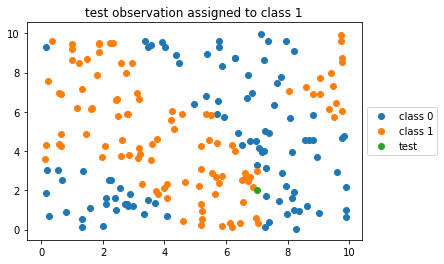

In [5]:
OBSERVATION = np.array([7, 2])
K = 5
label = knn(OBSERVATION, data, labels, K)

fig, ax = plt.subplots()
ax.scatter(data[index_0, 0], data[index_0, 1])
ax.scatter(data[index_1, 0], data[index_1, 1])
ax.scatter(OBSERVATION[0], OBSERVATION[1])
ax.legend(['class 0', 'class 1', 'test'], loc = 'center left', bbox_to_anchor = (1, 0.5))
_ = ax.set_title('test observation assigned to class ' + str(label))

The value of k is strongly depending on the data. As we increase the value of k we mitigate more the effect of noise, but the classification borders are less distinct.

In this example we observe the effect of increasing the value of k in classification results. Each coloured area indicates to which class would an observation in that area be assigned.

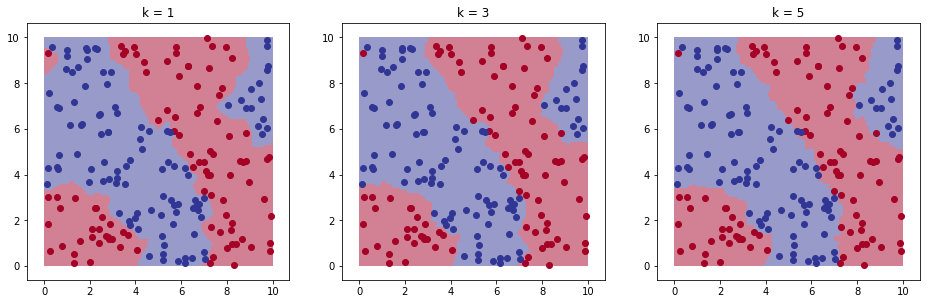

In [6]:
colormap = plt.cm.RdYlBu

def plot_area(k, ax, weighted = False):
    xx = np.linspace(0, 10, 100)
    res = np.zeros((xx.shape[0], xx.shape[0]))
    for i in range(xx.shape[0]):
        for j in range(xx.shape[0]):
            res[j, i] = knn(np.array([xx[i], xx[j]]), data, labels, k, weighted)

    ext = [0, 10, 0, 10]
    ax.imshow(res, zorder = 0, extent = ext, alpha = 0.5, cmap = colormap, origin = 'lower')
    ax.scatter(data[index_0, 0], data[index_0, 1], c = colormap(0))
    ax.scatter(data[index_1, 0], data[index_1, 1], c = colormap(256))

    aspect = res.shape[0] / float(res.shape[1]) * ((ext[1] - ext[0]) / (ext[3] - ext[2]))
    plt.gca().set_aspect(aspect)
    ax.set_title('k = ' + str(k))

fig, ax = plt.subplots(1, 3)
for k in range(3):
    plot_area(2 * k + 1, ax[k])
fig.set_figheight(8)
fig.set_figwidth(16)

A weighted approach in which the weight of each neighbour's vote for the classification of the test observation depends on the inverse of the distance from the test observation to the test one is recommended in those cases in which the data is not uniformly sampled. Let's see some classification results as we increase the value of k in the case of the weighted approach. 

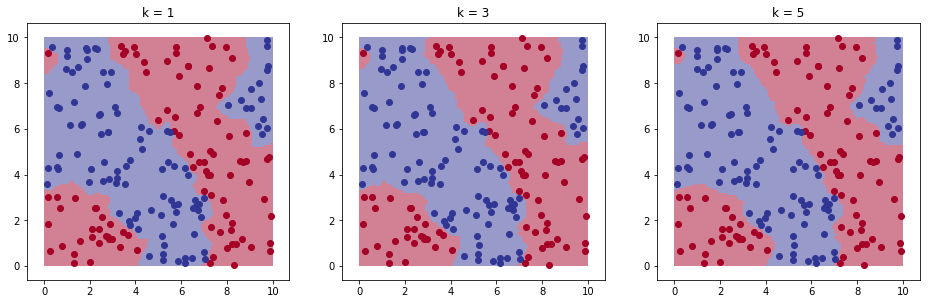

In [7]:
fig, ax = plt.subplots(1, 3)
for k in range(3):
    plot_area(2 * k + 1, ax[k], True)
fig.set_figheight(8)
fig.set_figwidth(16)